In [1]:
%matplotlib inline

from os.path import join
import os

import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from net_serialization import save_pytorch_data, load_pytorch_data

In [2]:
torchvision.__version__

'0.11.1+cu102'

In [3]:
vgg_model = models.vgg19(pretrained=True)

In [4]:
vgg_features = vgg_model.features

In [5]:
for param in vgg_features.parameters():
    param.requires_grad_(False)

In [6]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
_ = vgg_features.to(device)

In [9]:
class Image_Convolution_Transformation_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1024, 4, 1)
        self.conv2 = nn.Conv2d(1024, 512, 8, 1)
        self.conv3 = nn.Conv2d(512, 256, 16, 1)
        self.conv4 = nn.Conv2d(256, 128, 32, 1)
        self.conv5 = nn.Conv2d(128, 3, 64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x

In [10]:
class Image_Convolution_Transformation_Net_Small(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, 4, 1)
        self.conv2 = nn.Conv2d(256, 128, 32, 1)
        self.conv3 = nn.Conv2d(128, 3, 64, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x

In [11]:
def load_image(img_path, max_size, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        size = max_size
        
    if shape is not None:
        size = shape
    
    img_transformations = transforms.Compose([
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                            ])
    
    image = img_transformations(image).unsqueeze(0)
    
    return image

In [12]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [13]:
content = load_image(join('my_photos', 'IMG_6482.jpg'), 400).to(device)
style = load_image(join('images', 'MonaLisa.jpg'), 400, shape=content.shape[-2:]).to(device)

In [14]:
#content = load_image(join('Images', 'City.jpg'), 400).to(device)
#style = load_image(join('Images', 'StarryNight.jpg'), 400, shape=content.shape[-2:]).to(device)

(-0.5, 399.5, 599.5, -0.5)

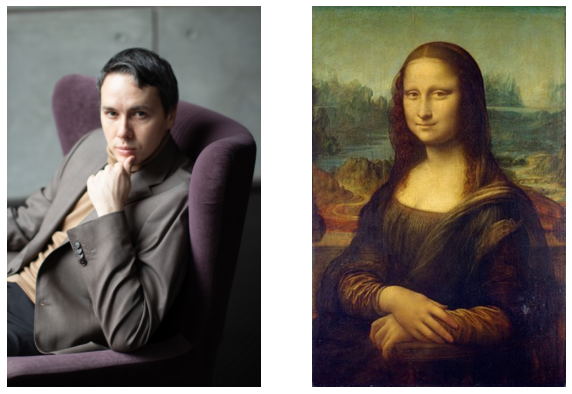

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.imshow(img_convert(content))
ax1.axis('off')
ax2.imshow(img_convert(style))
ax2.axis('off')

In [16]:
#net = Image_Convolution_Transformation_Net_Small()
net = Image_Convolution_Transformation_Net()
net.to(device)

Image_Convolution_Transformation_Net(
  (conv1): Conv2d(3, 1024, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(1024, 512, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(512, 256, kernel_size=(16, 16), stride=(1, 1))
  (conv4): Conv2d(256, 128, kernel_size=(32, 32), stride=(1, 1))
  (conv5): Conv2d(128, 3, kernel_size=(64, 64), stride=(1, 1))
)

In [17]:
content_shape = content.shape[-2:]

In [18]:
def get_features(image, model):
    target_layer_pos_to_name = {'0': 'conv1_1',
                               '5' : 'conv2_1',
                               '10': 'conv3_1',
                               '19': 'conv4_1',
                               '21': 'conv4_2', # content extraction
                               '28': 'conv5_1'}
    
    features = {}
    
    tensor = image
    
    for name, layer in model._modules.items():
        tensor = layer(tensor)
        if name in target_layer_pos_to_name:
            features[target_layer_pos_to_name[name]] = tensor
            
    return features

In [19]:
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

In [20]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [21]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [22]:
style_weights = {'conv1_1': 1.0, 
                 'conv2_1': 0.75, 
                 'conv3_1': 0.2, 
                 'conv4_1': 0.2, 
                 'conv5_1': 0.2}

content_weight = 1.0 # alpha
style_weight = 1e6 # beta

In [23]:
target = content.clone().requires_grad_(True).to(device)

In [24]:
checkpoint_dir = "test_conv_net"
if os.path.exists(checkpoint_dir) == False:
    os.makedirs(checkpoint_dir)

In [25]:
show_every = 300
#optimizer = optim.Adam([target], lr = 0.003)
target.requires_grad_(False)
optimizer = optim.Adam(net.parameters(), lr = 0.003)
steps = 10000

height, width, channels = img_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300
counter = 0
start = 1
best_loss = None

if os.path.isfile(join(checkpoint_dir, "last.json")) == True:
    print("Load last.json")
    checkpoint = load_pytorch_data(join(checkpoint_dir, "last.json"), net, optimizer)
    start = checkpoint['additional_data']['start']
    best_loss = checkpoint['additional_data']['best_loss']

Load last.json


In [27]:
target_shape = target.shape[-2:]
transformation_conv_img = transforms.Compose([transforms.Resize(target_shape)])

In [ ]:
for ii in range(start, steps + 1):
    processed_by_net_image = net.forward(target)
    processed_and_reshaped_image = transformation_conv_img(processed_by_net_image)
    
    target_features = get_features(processed_and_reshaped_image, vgg_features)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    style_loss = 0.0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    current_loss = total_loss.item()
    if best_loss is None or current_loss < best_loss:
        best_loss = current_loss
        save_pytorch_data(join(checkpoint_dir, "best.json"), net, optimizer, {'start': ii, 'best_loss': best_loss})
    
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        
        save_pytorch_data(join(checkpoint_dir, "last.json"), net, optimizer, {'start': ii, 'best_loss': best_loss})
        current_image = Image.fromarray(np.uint8(img_convert(processed_and_reshaped_image) * 255))
        current_image.save(join('processed_images', str(ii) + '.jpg'))
        plt.imshow(img_convert(processed_and_reshaped_image))
        plt.axis('off')
        plt.show()
        
    if ii % capture_frame == 0:
        image_array[counter] = img_convert(target)
        counter += 1

In [26]:
# show processed image
processed_by_net_image = net.forward(target)
processed_and_reshaped_image = transformation_conv_img(processed_by_net_image)
plt.imshow(img_convert(processed_and_reshaped_image))
plt.axis('off')
plt.show()

NameError: name 'transformation_conv_img' is not defined

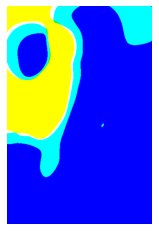

In [29]:
processed_and_reshaped_image = transformation_conv_img(processed_by_net_image)
plt.imshow(img_convert(processed_and_reshaped_image))
plt.axis('off')
plt.show()